In [39]:
import os
import sys

conda_lib_path = os.path.expanduser("~/miniconda3/envs/mask_detection/lib")
os.environ['LD_LIBRARY_PATH'] = f"{conda_lib_path}:/usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64"

try:
    import tensorflow as tf
    # Aktifkan Memory Growth agar tidak crash NUMA node
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"KONFIGURASI SUKSES {gpus}")
    else:
        print("GPU tidak ditemukan, tapi library berhasil dimuat. Cek nvidia-smi di terminal.")
except Exception as e:
    print(f"Error saat inisialisasi: {e}")

KONFIGURASI SUKSES [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import sys
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
warnings.filterwarnings("ignore")

In [41]:
train_dir = 'Dataset/train'
test_dir = 'Dataset/test'
img_size = (224, 224)
input_shape = (224, 224, 3) # Menggunakan RGB
batch_size = 32

In [42]:
# Load dataset 
full_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    color_mode='rgb', 
    shuffle=False
)

Found 9628 files belonging to 2 classes.


In [43]:
class_names = full_dataset.class_names
print(f"Kelas: {class_names}")
# Extract file paths dan labels
file_paths = full_dataset.file_paths
labels = []
for _, label_batch in full_dataset:
    # Flatten array dan convert ke int
    labels.extend([int(label) for label in label_batch.numpy().flatten()])
labels = labels[:len(file_paths)]

Kelas: ['with_mask', 'without_mask']


In [44]:
print(f"Total images: {len(file_paths)}")
print(f"Distribusi kelas: {pd.Series(labels).value_counts().sort_index().to_dict()}")
# Stratified split (80% train, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=123
)

Total images: 9628
Distribusi kelas: {0: 4776, 1: 4852}


In [45]:
print(f"\nSetelah stratified split:")
print(f"Train: {len(train_paths)} images")
print(f"Train distribusi: {pd.Series(train_labels).value_counts().sort_index().to_dict()}")
print(f"Validation: {len(val_paths)} images")
print(f"Validation distribusi: {pd.Series(val_labels).value_counts().sort_index().to_dict()}")
from tensorflow.keras import layers


Setelah stratified split:
Train: 7702 images
Train distribusi: {0: 3821, 1: 3881}
Validation: 1926 images
Validation distribusi: {0: 955, 1: 971}


In [46]:
# Fungsi untuk load dan preprocess image
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, img_size)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

In [47]:
# Buat tf.data.Dataset dari paths
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000, seed=123)
train_dataset = train_dataset.batch(batch_size)

In [48]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)

In [49]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [50]:
# Apply augmentasi hanya untuk training
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [51]:
# Prefetch untuk performa
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# Sample image path
sample_path = 'Dataset/train/with_mask/train_1000585.jpg'

In [52]:
# Sebelum transformasi (original)
img_before = keras.preprocessing.image.load_img(sample_path, target_size=img_size, color_mode='rgb')

In [53]:
# Setelah transformasi (apply normalisasi dan augmentasi)
img_array = keras.preprocessing.image.img_to_array(img_before)
img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension

In [54]:
# Normalize
img_normalized = preprocess_input(img_array)

In [55]:
# Apply augmentasi
img_augmented = data_augmentation(img_normalized, training=True)

In [56]:
# Visualisasi
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

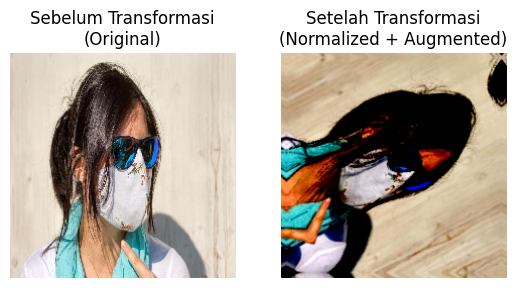

In [57]:
plt.subplot(1, 2, 1)
plt.imshow(img_before)
plt.title('Sebelum Transformasi\n(Original)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_augmented[0])
plt.title('Setelah Transformasi\n(Normalized + Augmented)')
plt.axis('off')

## Definisi Model MobileNetV2
Menggunakan MobileNetV2 sebagai base model (Transfer Learning) yang ringan dan cepat, ditambah lapisan klasifikasi khusus di bagian akhir.

In [58]:
plt.tight_layout()
plt.show()

# MobileNetV2 Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

<Figure size 640x480 with 0 Axes>

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Kompilasi Model
Menentukan algoritma optimasi (seperti Adam) dan fungsi loss (Binary Crossentropy) yang digunakan model untuk belajar.

In [59]:
model.summary()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [60]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## Training Model

In [61]:
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)
plt.figure(figsize=(12, 4))

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.8903 - loss: 0.2552 - val_accuracy: 0.9735 - val_loss: 0.0837
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9364 - loss: 0.1671 - val_accuracy: 0.9761 - val_loss: 0.0678
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9404 - loss: 0.1481 - val_accuracy: 0.9766 - val_loss: 0.0651
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9457 - loss: 0.1363 - val_accuracy: 0.9777 - val_loss: 0.0594
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9486 - loss: 0.1314 - val_accuracy: 0.9792 - val_loss: 0.0577
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9485 - loss: 0.1328 - val_accuracy: 0.9808 - val_loss: 0.0520
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9490 - loss: 0.1265 - val_accuracy: 0.9829 - val_loss: 0.0516
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9472 - loss: 0.1347 - va

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

## Visualisasi

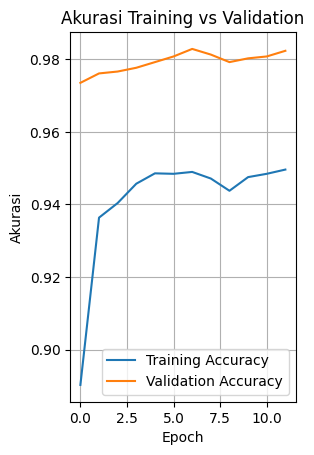

In [62]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

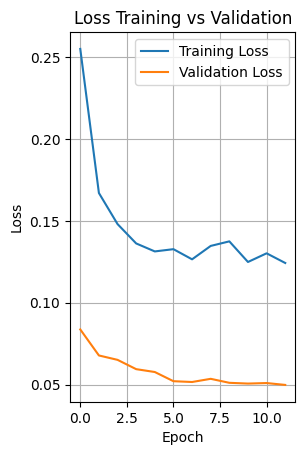

In [63]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## Evaluasi Model.

In [64]:
plt.tight_layout()
plt.show()
# Evaluasi model pada validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.2%}")
print(f"Validation Loss: {val_loss:.4f}")

<Figure size 640x480 with 0 Axes>

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9829 - loss: 0.0516
Validation Accuracy: 98.29%
Validation Loss: 0.0516


In [65]:
# Prediksi untuk confusion matrix
val_predictions = model.predict(val_dataset)
val_predictions_binary = (val_predictions > 0.5).astype(int).flatten()

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step


In [66]:
# Ambil label asli dari validation dataset
val_labels = []
for images, labels in val_dataset:
    val_labels.extend(labels.numpy())
val_labels = np.array(val_labels)

2026-02-06 17:02:24.472412: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [67]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(val_labels, val_predictions_binary)

In [68]:
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary, target_names=class_names))


Confusion Matrix:
[[931  24]
 [  9 962]]

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.99      0.97      0.98       955
without_mask       0.98      0.99      0.98       971

    accuracy                           0.98      1926
   macro avg       0.98      0.98      0.98      1926
weighted avg       0.98      0.98      0.98      1926



In [69]:
plt.tight_layout()
plt.show()
# Load semua file test
test_files = sorted(glob.glob(os.path.join(test_dir, '*.jpg')))
print(f"Total test images: {len(test_files)}")

<Figure size 640x480 with 0 Axes>

Total test images: 371


In [70]:
# Prediksi untuk setiap file test
predictions = []
filenames = []

In [71]:
for test_file in test_files:
    # Load dan preprocess image
    img = keras.preprocessing.image.load_img(test_file, target_size=img_size, color_mode='rgb')
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array, verbose=0)[0][0]
    pred_binary = 1 if pred > 0.5 else 0

    # Simpan hasil
    filename = os.path.basename(test_file)
    filenames.append(filename)
    predictions.append(pred_binary)

## Prediksi Data Test (Submission)

In [72]:
print(f"Prediksi selesai untuk {len(predictions)} gambar")
# Buat submission file
submission_df = pd.DataFrame({
    'filename': filenames,
    'label': predictions
})

Prediksi selesai untuk 371 gambar


In [74]:
# Simpan ke CSV
submission_df.to_csv('submission2.csv', index=False)
print("\nSubmission file saved as 'submission.csv'")
print(f"\nPreview submission:")
print(submission_df.head(10))
print(f"\nDistribusi prediksi:")
print(f"Class 0 (with_mask): {(submission_df['label'] == 0).sum()}")
print(f"Class 1 (without_mask): {(submission_df['label'] == 1).sum()}")


Submission file saved as 'submission.csv'

Preview submission:
           filename  label
0  test_2000000.jpg      0
1  test_2000002.jpg      0
2  test_2000006.jpg      0
3  test_2000008.jpg      1
4  test_2000009.jpg      1
5  test_2000011.jpg      0
6  test_2000012.jpg      0
7  test_2000015.jpg      1
8  test_2000019.jpg      0
9  test_2000021.jpg      1

Distribusi prediksi:
Class 0 (with_mask): 205
Class 1 (without_mask): 166
